In [1]:
import gym
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T

import numpy as np
from tqdm.auto import tqdm, trange

In [3]:
torch.random.manual_seed(3120)
np.random.seed(3120)

In [4]:
class PolicyNetwork(nn.Module):
    """
    A simple network that outputs action probabilities given the current state
    """
    def __init__(self, dropout):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(4,32)
        self.fc2 = nn.Linear(32,2)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return torch.softmax(x,dim=1)

In [5]:
class Trainer():
    """
    Trainer class for our Policy network.
    """
    def __init__(self, dropout=0.2, lr=1e-3, discounting_factor=0.99, mean_smoothing_factor=0.2):
        self.policy = PolicyNetwork(dropout=dropout)
        self.optim = torch.optim.RMSprop(self.policy.parameters(), lr=lr, momentum=0.3)
        self.env = gym.make('CartPole-v1').unwrapped
        self.discounting_factor = discounting_factor
        self.mean_smoothing_factor = mean_smoothing_factor
    
    def test_episode(self, show_display=False):
        self.policy.eval()
        with torch.no_grad():
            total_reward = 0
            state = torch.tensor(self.env.reset().astype(np.float32)).unsqueeze(0)
            if show_display:
                img = plt.imshow(self.env.render(mode='rgb_array')) # only call this once
            done = False
            ep_len=0
            while(done==False):
                if show_display:
                    img.set_data(self.env.render(mode='rgb_array')) # just update the data
                    display.display(plt.gcf())
                    display.clear_output(wait=True)
                ep_len+=1
                action_probs = self.policy(state).numpy().flatten()
                action = np.random.choice(np.arange(0,2), p = action_probs)
                state,reward,done,_ = self.env.step(action)
                state = torch.tensor(state.astype(np.float32)).unsqueeze(0)
                total_reward+=reward
                if total_reward>5000:
                    print("Reached Max Reward Limit!")
            print("Reward received:", total_reward)
    
    def run_epsiode(self):
        """
        Run an episode in the environment using current policy and 
        store rewards received and log probabilities at each step
        """
        self.policy.train()
        state = torch.tensor(self.env.reset().astype(np.float32)).unsqueeze(0)
        self.saved_log_probs = []
        self.rewards = []
        
        # do not go into infinite while loop during training
        for step in range(1000):
            action_probs = self.policy(state).squeeze()
            action = np.random.choice(np.arange(0,2), p = action_probs.detach().cpu().numpy())
            self.saved_log_probs.append(torch.log(action_probs+1e-6))
            state, reward, done, _ = self.env.step(action)
            state = torch.tensor(state.astype(np.float32)).unsqueeze(0)
            self.rewards.append(reward)
            if done:
                break
        return sum(self.rewards)
    
    def train_episode(self):
        """
        Run one episode and train policy network using REINFORCE
        using the discounted rewards and log probabilities of each action
        """
        train_ep_reward = self.run_epsiode()
        discounted_rewards = []
        running_reward = 0
        for r in self.rewards[::-1]:
            running_reward=r+self.discounting_factor*running_reward
            discounted_rewards.append(running_reward)
        discounted_rewards = discounted_rewards[::-1]
        
        discounted_rewards = torch.tensor(discounted_rewards)
        discounted_rewards = (discounted_rewards - discounted_rewards.mean())/ (discounted_rewards.std() + 1e-6)
        
        self.optim.zero_grad()
        policy_loss=0
        for log_prob,r in zip(self.saved_log_probs, discounted_rewards):
            policy_loss-=(log_prob*r).sum()
        policy_loss.backward()
        self.optim.step()
        return policy_loss.item(), train_ep_reward
            
        
    def train(self, training_episodes):
        loss_history = []
        reward_history = []
        epoch_iter = trange(training_episodes)
        epoch_iter.set_description_str("Training episodes completed")
        running_loss = 0
        running_reward = 0
        for epoch in epoch_iter:
            loss,reward = self.train_episode()
            loss_history.append(loss)
            reward_history.append(reward)
            running_loss = self.mean_smoothing_factor*loss + (1-self.mean_smoothing_factor)*running_loss
            running_reward = self.mean_smoothing_factor*reward + (1-self.mean_smoothing_factor)*running_reward
            epoch_iter.set_postfix_str("Loss:{}, Reward:{}".format(round(running_loss,4), round(running_reward,4)))
        return loss_history, reward_history

In [6]:
z = Trainer()

Let's test a random policy and see how much reward it gets

Reward received: 19.0


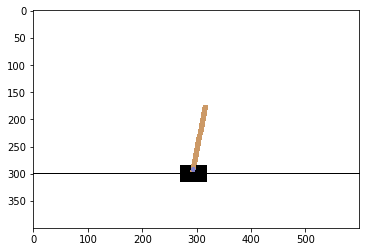

In [7]:
z.test_episode(show_display=True)

As the training progresses the reward per episode increases and training episodes start becoming longer. The longer episodes lead to slower progression of episodes.

In [8]:
loss,reward = z.train(training_episodes=800)

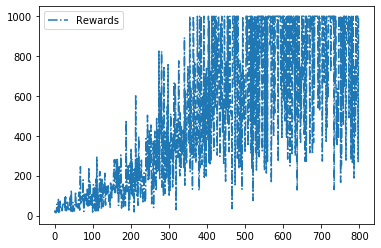

In [9]:
plt.plot(reward, "-.", label="Rewards")
plt.legend()

Now, it is time to test the policy learned by our model. 

Reward received: 521.0


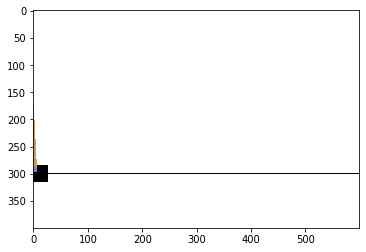

In [10]:
z.test_episode(show_display=True)